# Dimensionality Reduction #

Today's topic is all about reducing the number of dimensions in a dataset. Too many dimensions can significantly slow down a machine learning model and lead to overfitting. In the past, we have talked a little about feature importance, correlation, and variance. This notebook formalizes these analysis techniques together and compares them on a common dataset.

### Correlation ###

Correlation measures the linear relationship between two variables. As one variable increases, does the other variable increase at a consistent rate? Does the other variable decrease at a consistent rate? If either of these are true, then it means that the variables are correlated. Knowing the value of one helps estimate the value of the other--but correlation does not imply causation!!1! Correlated variables have a higher chance for being redundant. 

Correlation can be calculated this way, where $X_i$ and $Y_i$ are the individual datapoints and $\mu_X$ and $\mu_Y$ are the means of X and Y.

$$
\rho_{X,Y} = \frac{\sum (X_i - \mu_X)(Y_i - \mu_Y)}{\sqrt{\sum (X_i - \mu_X)^2} \cdot \sqrt{\sum (Y_i - \mu_Y)^2}}
$$

The equation can also be expressed this way, where $\overline{x}$ and $\overline{y}$ are the means of variables $x$ and $y$, $S_x$ and $S_y$ are the standard deviations, and $n$ is the number of samples.

$$
r = \frac{\sum_{i=1}^n (x_i - \overline{x})(y_i - \overline{y})}{(n-1)S_x S_y}
$$

I realize that one equation uses $\rho_{X,Y}$ and other uses $r$ as the correlation variables. These are both standard symbols, $r$ is used more in applications like machine learning whereas $\rho{X,Y}$ is more for theoretical contexts.

### Variance ###

Variance measures the distribution of a particular variable from its mean. You can think of it as the amount of dispersion or the spread of the data. For example, the amount of precipitation in the Sahara Desert has low variance; same with the precipitation in Hawaii. But there is a high variance in amount of precipitation in the Sierra Nevada Mountains. Some years it is very high (yay--good for skiing, rafting, and watering our gardens) and other years it is very low (doh--water restrictions). Features with low variance are unlikely to have much predictive power because they don't change very much.

$$
\sigma^2_X = \frac{1}{n} \sum_{i=1}^{n} (X_i - \mu_X)^2
$$

Notice that variance is measured in squared units, which is helpful for our PCA calculations but not so much for other applications. We often take its square root to get the standard deviation, which is in the same unit as the original variable and easier to interpret. (We’ll use variance for PCA, but now you understand why it's value is squared!)

## Correlation Matrices and Principal Component Analysis ##

So far, we’ve seen how correlation and variance can help us identify redundant or uninformative features. But how do we systematically transform our dataset to keep the most useful information while removing noise? This is where Principal Component Analysis (PCA) comes in.

We use correlation and variance to identify redundant or uninformative features. Correlation is usually analyzed with a heatmap of a correlation matrix (we’ll focus on this first). Variance is analyzed through Principal Component Analysis (PCA), a technique that helps us reduce dimensionality while preserving as much information as possible. Luckily, we can let the libraries handle most of the PCA calculations!


## Wine Dataset ##
We are going to use the Wine Dataset to predict the type of grapes used in a bottle of wine based on the chemical characteristics of the wine. This dataset is common for machine learning practice and benchmarking. Like the MNIST and Iris datasets, it is included as part of SKLearn and can be loaded directly with a simple function call.

The wine dataset is officially housed in the [UCI repository](https://archive.ics.uci.edu/dataset/109/wine).

### Why This Dataset? ###
The Wine Database is good candidate for (a) Feature Selection and (b) Principal Component Analaysis. Some datasets are ideal for feature selection but not PCA, and vise-versa. This one can benefit from either technique because it has multiple features with strong correlation and all of the features are *continuous numeric* values.

### Features ###
Each sample in this dataset represents a wine from the same region of Italy and includes the following chemical characteristics:

* Alcohol: Percentage of alcohol in the wine.
* Malic acid: Amount of malic acid present.
* Ash: Residual mineral content left after burning.
* Alcalinity of ash: A measure of how *basic* the ash content is ("basic" in the chemical pH sense).
* Magnesium: Magnesium content in the wine.
* Total phenols: Total phenolic compounds (affects flavor & mouthfeel).
* Flavanoids: A subgroup of phenols, impacting bitterness and antioxidant properties.
* Nonflavanoid phenols: Phenolic compounds not part of flavonoids.
* Proanthocyanins: A class of polyphenols related to color and astringency.
* Color intensity: Depth of wine color.
* Hue: Shade of the wine color.
* OD280/OD315 of diluted wines: Ratio of absorbance at specific wavelengths, related to phenolic content.
* Proline: An amino acid associated with wine aging.

### Classes ###
There are three varieties of grapes, labeled as class 0, 1, and 2.

In [2]:
from sklearn.datasets import load_wine
import pandas as pd

# Load the wine dataset
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df["target"] = wine.target
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


### Plain Model ###

Here is a model using straight Logistic Regression on all of the original features. Logistic Regression is a new algorithm (for us) that models probabilities using a sigmoid function. It is related to Linear Regression but is specifically designed for classification tasks. Logistic Regression is susceptible to differences in data ranges, so we must standardize the features.

Important note: Standardization scales the data to have a mean of 0 and a standard deviation of 1, making it useful for algorithms sensitive to feature magnitude, like Logistic Regression and PCA. In contrast, normalization rescales values to a fixed range (e.g., [0,1]), which is useful for algorithms like Neural Networks and KNN. In general, algorithms that are sensitive to outliers and large variations perform better with standardization than normalization.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
# Set random_state for reproducibility
# Stratify the split to keep the relative distribution of classes (y)
X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64, stratify=y)

# Standardize the features
# Remember that we fit *AND* transform on X_train but only transform X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.8889
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       0.92      0.79      0.85        14
           2       0.90      0.90      0.90        10

    accuracy                           0.89        36
   macro avg       0.89      0.90      0.89        36
weighted avg       0.89      0.89      0.89        36



### Correlation Matrix ###

A correlation matrix measures the Pearson Correlation Coefficient between every unique pair of features. The output is often visualized as a heatmap, where:
* Strong positive correlations (close to +1) appear in dark red.
* Strong negative correlations (close to -1) appear in dark blue.
* Weak or no correlation (near 0) appears in white or light colors.

You can ignore the diagonal column of the correlation matrix because it always shows each variable correlated with itself, which is always a perfect correlation of 1 (by definition).

A correlation matrix is symmetrical, meaning the upper-left and bottom-right halves contain the same values. It contains redundant information. You only need to analyze one half of the diagram.

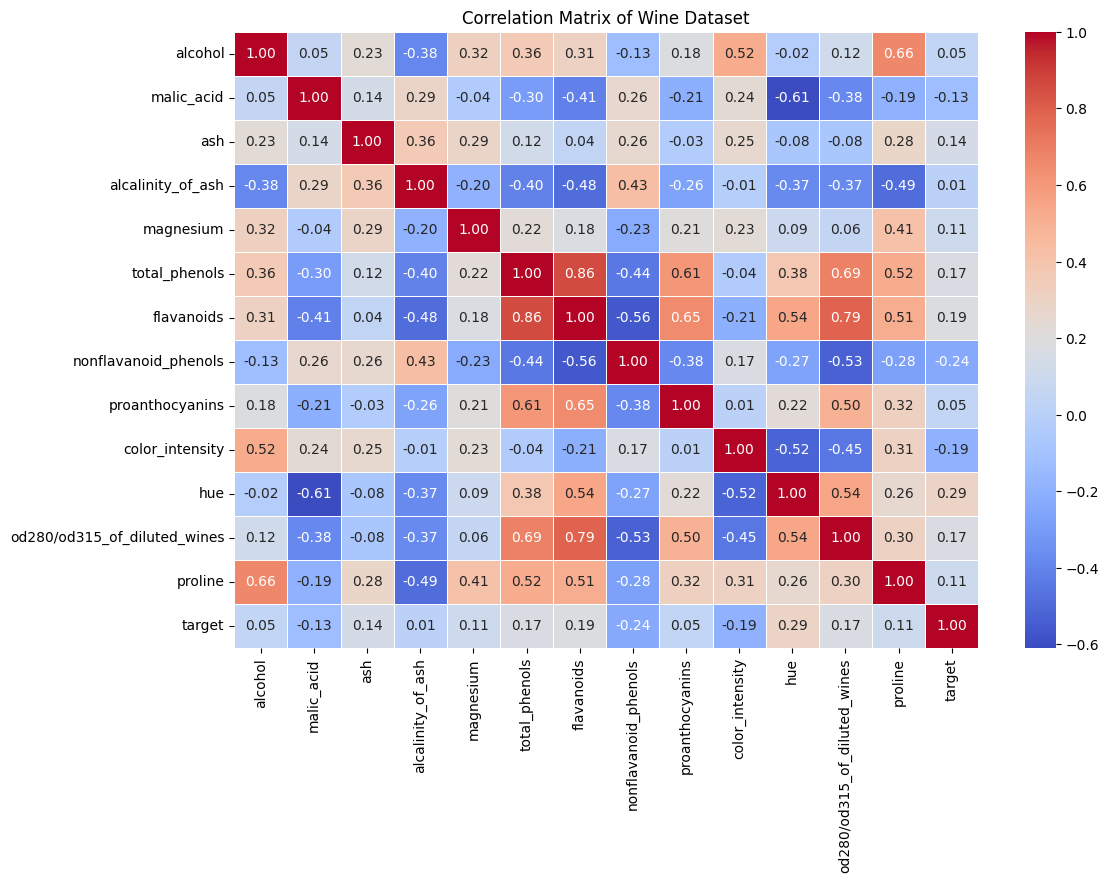

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas comes with a built-in correlation matrix function so we don't need
# to write the Pearson calculation ourselves... but we need to convert X_train
# and y_train from Numpy Arrays back into a Pandas DataFrame
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['target'] = pd.Series(y_train)
correlation_matrix = df_train.corr()

# Plot the matrix using labels, round to 2 decimal places, etc. etc.
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Wine Dataset")
plt.show()


In [5]:
for series in correlation_matrix:
    print(correlation_matrix[series].sort_values(ascending=False).head(2))
    print("\n")

alcohol    1.000000
proline    0.661288
Name: alcohol, dtype: float64


malic_acid           1.000000
alcalinity_of_ash    0.285558
Name: malic_acid, dtype: float64


ash                  1.000000
alcalinity_of_ash    0.363123
Name: ash, dtype: float64


alcalinity_of_ash       1.000000
nonflavanoid_phenols    0.430012
Name: alcalinity_of_ash, dtype: float64


magnesium    1.000000
proline      0.411224
Name: magnesium, dtype: float64


total_phenols    1.000000
flavanoids       0.857604
Name: total_phenols, dtype: float64


flavanoids       1.000000
total_phenols    0.857604
Name: flavanoids, dtype: float64


nonflavanoid_phenols    1.000000
alcalinity_of_ash       0.430012
Name: nonflavanoid_phenols, dtype: float64


proanthocyanins    1.000000
flavanoids         0.648847
Name: proanthocyanins, dtype: float64


color_intensity    1.000000
alcohol            0.521852
Name: color_intensity, dtype: float64


hue           1.000000
flavanoids    0.544241
Name: hue, dtype: float64


od280

In [6]:
# It will be easier to process the training and test data if we convert
# them back to DataFrames

X_train = pd.DataFrame(X_train, columns=X.columns)
y_train = pd.Series(y_train, name='target')

X_test = pd.DataFrame(X_test, columns=X.columns)
y_test = pd.Series(y_test, name='target')

### Strongly Correlated Features ###
Ignoring the bottom row (target) and the right-most column (target), we can analye the correlation values between features. If two features are strongly correlated in either the postivive (1.00) or negative (-1.00) direction, it means we can *probably* remove one of the features because the other feature provides the model with all of the important predictability information.

#### Strong Positive Correlation ####
* `flavanoids` and `total_phenols` (0.86)
* `od280/od315_of_diluted_wines` and `flavanoids` (0.79)
* `od280/od315_of_diluted_wines` and `total_phenols` (0.69)

#### Strong Negative Correlation ####
None of the features strongly negative (inverse) correlations. The "highest" value is between `hue` and `malic_acid` but it is only -0.56, which is very rarely considered strong enough to drop a feature. 

In [7]:
X_train = X_train.drop(columns=["total_phenols", "od280/od315_of_diluted_wines"])
X_test = X_test.drop(columns=["total_phenols", "od280/od315_of_diluted_wines"])

### Target Correlation ###

Features with very low correlation to the target might be weak predictors and could be considered for removal. The low correlation coefficient means that there is weak *linear* relationship between the feature and the prediction. However, we must be careful—sometimes a feature has a strong relationship with the target when combined with another feature (feature interaction), or it has a non-linear relationship that Pearson correlation fails to capture. So it's best to apply domain knowledge and use test metrics to compare the accuracy of models created with the feature and also without the feature.

In this case, there are three features with weak correlation to the target
* `alcalinity_of_ash` (0.01)
* `alcohol` (0.05)
* `proanthocyanins` (0.05)

In [8]:
X_train = X_train.drop(columns=["alcalinity_of_ash", "alcohol", "proanthocyanins"])
X_test = X_test.drop(columns=["alcalinity_of_ash", "alcohol", "proanthocyanins"])

### Test the New Model ###
Now that we have removed three columns due to their correlation values, it's time to test the new model.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Standardize the features
# Remember that we fit *AND* transform on X_train but only transform X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.8611
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       0.91      0.71      0.80        14
           2       0.90      0.90      0.90        10

    accuracy                           0.86        36
   macro avg       0.87      0.87      0.86        36
weighted avg       0.87      0.86      0.86        36



### Results ###

Through correlation analysis, we have dropped almost half of the features and reduced the test accuracy by approximately 2%. Does this mean that our final model should omit the five features: total_phenols, od280/od315_of_diluted_wines, alcalinity_of_ash, alcohol, and proanthocyanins? The answer is likely yes, but it really depends on the situation. Reducing the features will improve computational efficiency and *probably* reduce overfitting but at the cost of test accuracy.

## Feature Importance ##

Let's avoid data leakage by continuing to use the original train/test split. Decision Tree algorithms are not as susceptible to differences in scaling, so we don't need to standardize our data.

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
# This is the same random_state and stratification as before (for consistency)
X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64, stratify=y)

model = RandomForestClassifier(random_state=17)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.9444
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.86      0.92        14
           2       0.91      1.00      0.95        10

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.95        36
weighted avg       0.95      0.94      0.94        36



In [11]:
# Feature importance is a measurement specific to Random Forest and Decision Tree Models
feature_data = zip(X_train.columns, abs(model.feature_importances_))
feature_importance = pd.DataFrame(feature_data, columns=["feature", "coefficient"])
feature_importance.sort_values("coefficient", ascending=False).reset_index(drop=True)

,feature,coefficient
0,proline,0.186066
1,flavanoids,0.150705
2,color_intensity,0.147780
3,od280/od315_of_diluted_wines,0.118834
4,hue,0.112506
5,alcohol,0.112451
6,total_phenols,0.046831
7,malic_acid,0.035075
8,alcalinity_of_ash,0.027751
9,proanthocyanins,0.018893


### Relative Importances ###

Using Decision Trees, we find that the five least important features are `ash`, `nonflavanoid_phenols`, `magnesium`, `proanthocyanins`, and `alcalinity_of_ash`. Let's try removing them and see how our updated model performs.

In [12]:
X_train = pd.DataFrame(X_train, columns=X.columns)
y_train = pd.Series(y_train, name='target')

X_test = pd.DataFrame(X_test, columns=X.columns)
y_test = pd.Series(y_test, name='target')

to_drop = ["nonflavanoid_phenols", "ash", "proanthocyanins", "alcalinity_of_ash", "magnesium"]
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.9444
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.86      0.92        14
           2       0.91      1.00      0.95        10

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.95        36
weighted avg       0.95      0.94      0.94        36



### Results ###

Through feature importance analysis, we have dropped almost half of the features without affecting the accuracy of our model at all. Does this mean that our final model should omit the five features: ash, nonflavanoid_phenols, magnesium, proanthocyanins, and alcalinity_of_ash? The answer is likely yes, but it really depends on the situation. Reducing the features will improve computational efficiency and *probably* reduce overfitting but we might have just gotten lucky for accuracy with this train/test split.

#### Common Features ####

Notice that three of the features were common to both analysis techniques. These features should almost certainly be dropped because they are likely redundant or uninformative. What you decide to do with the two weakly correlated features, or the two unimportant features, depends on which algorithm you use for your final model and the particular tradeoffs between efficiency and accuracy, along with the likelihood of overfitting the training data.

## Principal Component Analyasis (PCA) ##

Principal Component Analysis (PCA) is a technique for reducing the number of dimensions in a dataset while keeping as much information as possible. Instead of analyzing features individually, PCA finds new axes (principal components) that capture the most variance in the data. This helps remove redundancy, improve model efficiency, and even reveal hidden structure in the dataset.

PCA works by transforming the original features into a new set of uncorrelated features, ordered by how much variance they explain. The first principal component captures the most variance, the second captures the next most, and so on. If a small number of components capture most of the variance, we can drop the rest without losing much information.

Since PCA is sensitive to scale, we must standardize the features before applying it. We typically let the libraries handle the calculations, but it's helpful to understand that PCA is fundamentally based on eigenvectors and eigenvalues from linear algebra.

In the next section, we'll run PCA on our dataset and see how much dimensionality we can reduce while keeping most of the information.

**Note:** I ran out of time and asked ChatGPT to write this section based on the length and style of my writing in this notebook.

Explained Variance by PC1: 0.37
Explained Variance by PC2: 0.19
Total Variance Explained by First 2 Components: 0.57


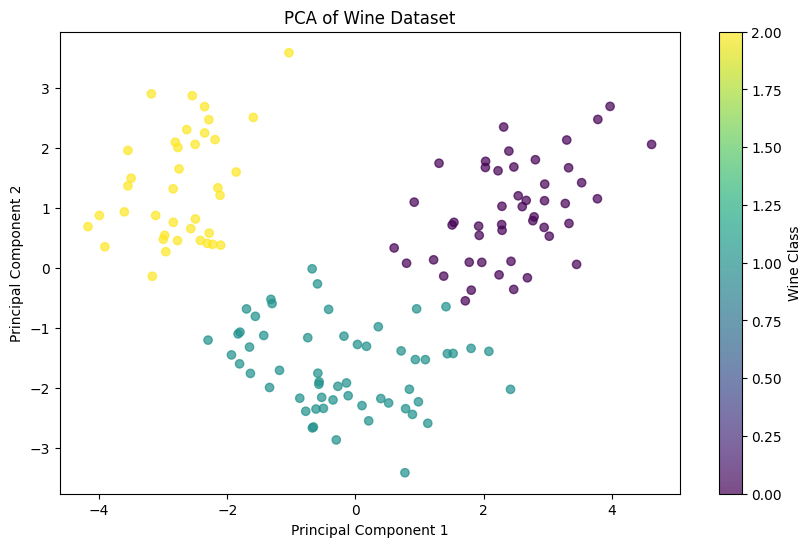

In [13]:

import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the wine dataset
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df["target"] = wine.target

# Split the data into training and testing sets
# Set random_state for reproducibility
# Stratify the split to keep the relative distribution of classes (y)
X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64, stratify=y)

# Standardize the data (required for PCA)
# Reminder, this transforms the features to have mean=0, variance=1
# instead of values between [0, 1]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Apply PCA (reduce to 2 principal components for visualization)
# Note that this very well might over-simplify the data and lead to inaccuracies
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=["PC1", "PC2"])

# View the variance of the PCA-transformed data
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by PC1: {explained_variance[0]:.2f}")
print(f"Explained Variance by PC2: {explained_variance[1]:.2f}")
print(f"Total Variance Explained by First 2 Components: {sum(explained_variance):.2f}")

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train["PC1"], X_train["PC2"], c=y_train, cmap="viridis", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Wine Dataset")
plt.colorbar(scatter, label="Wine Class")
plt.show()

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Apply the same standardization and PCA transformation
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)
X_test = pd.DataFrame(X_test, columns=["PC1", "PC2"])

# Train and test the Logistic Regression model
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy (after PCA): {accuracy_lr:.4f}")

# Train and test the Random Forest model
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy (after PCA): {accuracy_rf:.4f}")


Logistic Regression Accuracy (after PCA): 0.8611
Random Forest Accuracy (after PCA): 0.8611


### Results ###

Notice that we've shrunk the data from 13 features down to only 2 features. The accuracy of our for Logistic Regression model has not dropped at all, but our Random Forest model does not perform quite as well. This seems like a no-brainer decision, at least for Logistic Regression. But have we lost anything in the process? Yes, the original 13 features each had a specific meaning and certain level of explainability on our model. Once we apply PCA, we resort to using statistical measures that are difficult, if not impossible, to trace back to their original data. This is especially problematic in models that are susceptible to training bias.

### Choosing PCA Dimensions ###

Why did we choose the number of PCA components to be two? Because it made a pretty graph that was easy for us to interpret. Wouldn't it be better to have an automatic way to find the smallest number of components that still captures "enough" of the dataset's information? We would want to minimize the number of components without sacrificing the overall variance below some certain threshold. Think of it as something like the K-Means WSSE Elbow Plots. There is a way to do this, and all we have to do is specify a variance threshold for the `n_components` parameter. In this case, we tell PCA to retain at least 90% of the dataset’s variance by automatically selecting the optimal number of components.

Note: This is back to my own writing.

In [15]:

import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Load the wine dataset
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df["target"] = wine.target
X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64, stratify=y)

# Standardize and apply PCA
# *** NOTICE THAT n_components IS SET TO A VARIANCE THRESHOLD ***
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
pca = PCA(n_components=0.90)
X_train = pca.fit_transform(X_train)
print(f"Number of PCA componets: {pca.n_components_}")

# We don't care about a dataframe in this case
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

# Train and test the Logistic Regression model
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy (after PCA): {accuracy_lr:.4f}")
print(classification_report(y_test, y_pred_lr))
# Train and test the Random Forest model
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy (after PCA): {accuracy_rf:.4f}")
print(classification_report(y_test, y_pred_rf))


Number of PCA componets: 8
Logistic Regression Accuracy (after PCA): 0.9167
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.92      0.86      0.89        14
           2       0.90      0.90      0.90        10

    accuracy                           0.92        36
   macro avg       0.92      0.92      0.92        36
weighted avg       0.92      0.92      0.92        36

Random Forest Accuracy (after PCA): 0.8611
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.91      0.71      0.80        14
           2       0.91      1.00      0.95        10

    accuracy                           0.86        36
   macro avg       0.87      0.88      0.87        36
weighted avg       0.87      0.86      0.86        36

